# **POETRY BINARY**

## **Preliminary steps**

In [4]:
### PACKAGES

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

In [5]:
### FUNCTIONS

from src.configs import constants, ml_config, names
from src.libs import preprocessing, evaluation, visualization
from src.embedding.tf_idf import TfIdfEmbedding
from src.embedding.punctuation import PunctuationEmbedding
from src.classifier.classifier import LightGBMClassifier, RFClassifier, NBClassifier

## **DATA**

In [6]:
### LOAD DATA

df_poetry_gpt = preprocessing.load_dataset(source="GPT", type="POETRY")
df_poetry_bard = preprocessing.load_dataset(source="BARD", type="POETRY")
df_poetry_human = preprocessing.load_dataset(source="Human", type="POETRY")

df_essay_gpt = preprocessing.load_dataset(source="GPT", type="ESSAY")
df_essay_bard = preprocessing.load_dataset(source="BARD", type="ESSAY")
df_essay_human = preprocessing.load_dataset(source="Human", type="ESSAY")

df_story_gpt = preprocessing.load_dataset(source="GPT", type="STORY")
df_story_bard = preprocessing.load_dataset(source="BARD", type="STORY")
df_story_human = preprocessing.load_dataset(source="Human", type="STORY")

Time taken to load dataset: 0.007765769958496094 seconds
Time taken to load dataset: 0.011750459671020508 seconds
Time taken to load dataset: 0.3128995895385742 seconds
Time taken to load dataset: 0.010357379913330078 seconds
Time taken to load dataset: 0.010880470275878906 seconds
Time taken to load dataset: 0.08049225807189941 seconds
Time taken to load dataset: 0.007866859436035156 seconds
Time taken to load dataset: 0.014326810836791992 seconds
Time taken to load dataset: 0.013185977935791016 seconds


In [7]:
### GET TRAIN SPLIT

df_train_poetry_gpt, df_test_poetry_gpt = preprocessing.train_valid_split(df_poetry_gpt)
df_train_poetry_bard, df_test_poetry_bard = preprocessing.train_valid_split(
    df_poetry_bard
)
df_train_poetry_human, df_test_poetry_human = preprocessing.train_valid_split(
    df_poetry_human
)

df_train_essay_gpt, df_test_essay_gpt = preprocessing.train_valid_split(df_essay_gpt)
df_train_essay_bard, df_test_essay_bard = preprocessing.train_valid_split(df_essay_bard)
df_train_essay_human, df_test_essay_human = preprocessing.train_valid_split(
    df_essay_human
)

df_train_story_gpt, df_test_story_gpt = preprocessing.train_valid_split(df_story_gpt)
df_train_story_bard, df_test_story_bard = preprocessing.train_valid_split(df_story_bard)
df_train_story_human, df_test_story_human = preprocessing.train_valid_split(
    df_story_human
)

In [8]:
### GET FULL DATASETS

df_train_poetry = preprocessing.group_llms(
    preprocessing.get_poetry_dataset(
        df_train_poetry_gpt,
        df_train_poetry_bard,
        df_train_poetry_human,
        samples_per_source=min(
            len(df_train_poetry_gpt),
            len(df_train_poetry_bard),
            len(df_train_poetry_human),
        ),
    )
)
df_test_poetry = preprocessing.group_llms(
    preprocessing.get_poetry_dataset(
        df_test_poetry_gpt,
        df_test_poetry_bard,
        df_test_poetry_human,
        samples_per_source=None,
    )
)

df_test_essay = preprocessing.group_llms(
    preprocessing.get_essay_dataset(
        df_test_essay_gpt,
        df_test_essay_bard,
        df_test_essay_human,
        samples_per_source=None,
    )
)

df_test_story = preprocessing.group_llms(
    preprocessing.get_story_dataset(
        df_test_story_gpt,
        df_test_story_bard,
        df_test_story_human,
        samples_per_source=None,
    )
)

In [9]:
### SPLIT FEATURES AND LABELS

X_train_poetry, y_train_poetry = preprocessing.split_features_and_labels(
    df_train_poetry
)
X_test_poetry, y_test_poetry = preprocessing.split_features_and_labels(df_test_poetry)
X_test_essay, y_test_essay = preprocessing.split_features_and_labels(df_test_essay)
X_test_story, y_test_story = preprocessing.split_features_and_labels(df_test_story)

## **CLASSIFICATION USING PUNCTUATION & RANDOM FOREST**

In [10]:
ID_EXPERIMENT = 211

In [11]:
### EMBEDDING

embedding_211 = PunctuationEmbedding(ID_EXPERIMENT)

X_train_poetry_211 = embedding_211.transform(X=X_train_poetry)
X_test_poetry_211 = embedding_211.transform(X=X_test_poetry)
X_test_essay_211 = embedding_211.transform(X=X_test_essay)
X_test_story_211 = embedding_211.transform(X=X_test_story)

In [12]:
### CLASSIFIER

classifier_211 = LightGBMClassifier(ID_EXPERIMENT)

classifier_211.train(X_train=X_train_poetry_211, y_train=y_train_poetry)

metrics_poetry_211 = classifier_211.evaluate(X_test_poetry_211, y_test_poetry)
metrics_essay_211 = classifier_211.evaluate(X_test_essay_211, y_test_essay)
metrics_story_211 = classifier_211.evaluate(X_test_story_211, y_test_story)

print(f"Metrics on poetry: {metrics_poetry_211}")
print(f"Metrics on essay: {metrics_essay_211}")
print(f"Metrics on story: {metrics_story_211}")

Metrics on poetry: {'accuracy': 0.6867897727272727, 'precision': 0.5289158874676582, 'recall': 0.8073778422835027, 'f1': 0.46125394020006194}
Metrics on essay: {'accuracy': 0.6789667896678967, 'precision': 0.4518670649738611, 'recall': 0.39127867746288797, 'f1': 0.4152094649899546}
Metrics on story: {'accuracy': 0.3090909090909091, 'precision': 0.44015957446808507, 'recall': 0.4625, 'f1': 0.2977150537634409}


In [13]:
### INTERPRETABILITY - FEATURE IMPORTANCE

dim_names_211 = embedding_211.map_dimensions_to_names()
feature_importances_211 = classifier_211.get_feature_importance()
most_important_features_211 = np.argsort(feature_importances_211)[-10:][::-1]
for i in most_important_features_211:
    print(f"{dim_names_211[i]}: {feature_importances_211[i]}")

ratio_words_per_sentence: 812
ratio_odd_characters: 682
ratio_punctuations: 560


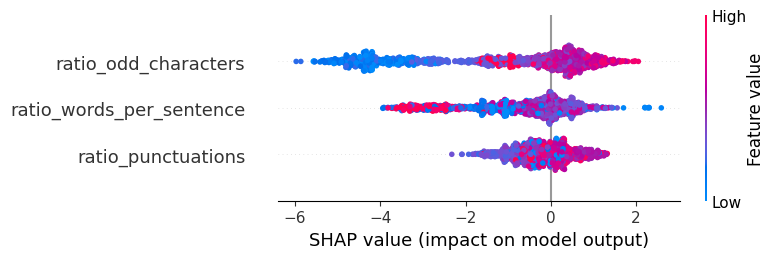

In [14]:
### INTERPRETABILITY - SHAP VALUES

explainer_211 = shap.Explainer(classifier_211.classifier)

if hasattr(X_test_poetry_211, "toarray"):
    X_test_poetry_211 = X_test_poetry_211.toarray()

# Calculate SHAP values
shap_values_211 = explainer_211(X_test_poetry_211)

# Visualize the SHAP values
shap.summary_plot(shap_values_211, X_test_poetry_211, feature_names=dim_names_211)

## **CLASSIFICATION USING TF-IDF & LGBM**

In [15]:
ID_EXPERIMENT = 111

In [16]:
### EMBEDDING

embedding_111 = TfIdfEmbedding(ID_EXPERIMENT)

embedding_111.fit(X=X_train_poetry)

X_train_poetry_111 = embedding_111.transform(X=X_train_poetry)
X_test_poetry_111 = embedding_111.transform(X=X_test_poetry)
X_test_essay_111 = embedding_111.transform(X=X_test_essay)
X_test_story_111 = embedding_111.transform(X=X_test_story)

In [17]:
### CLASSIFIER

classifier_111 = LightGBMClassifier(ID_EXPERIMENT)

classifier_111.train(X_train=X_train_poetry_111, y_train=y_train_poetry)

metrics_poetry_111 = classifier_111.evaluate(X_test_poetry_111, y_test_poetry)
metrics_essay_111 = classifier_111.evaluate(X_test_essay_111, y_test_essay)
metrics_story_111 = classifier_111.evaluate(X_test_story_111, y_test_story)

print(f"Metrics on poetry: {metrics_poetry_111}")
print(f"Metrics on essay: {metrics_essay_111}")
print(f"Metrics on story: {metrics_story_111}")

Metrics on poetry: {'accuracy': 0.9012784090909091, 'precision': 0.5864234464190072, 'recall': 0.9332607643928399, 'f1': 0.6206712757029362}
Metrics on essay: {'accuracy': 0.6014760147601476, 'precision': 0.4358288770053476, 'recall': 0.3299595141700405, 'f1': 0.37557603686635943}
Metrics on story: {'accuracy': 0.4909090909090909, 'precision': 0.5571428571428572, 'recall': 0.5666666666666667, 'f1': 0.4866666666666667}


In [18]:
### INTERPRETABILITY - FEATURE IMPORTANCE

dim_names_111 = embedding_111.map_dimensions_to_names()
feature_importances_111 = classifier_111.get_feature_importance()
most_important_features_111 = np.argsort(feature_importances_111)[-10:][::-1]
for i in most_important_features_111:
    print(f"{dim_names_111[i]}: {feature_importances_111[i]}")

beauty: 102
world: 85
like: 81
let: 64
peace: 63
hope: 62
life: 61
make: 44
man: 44
love: 42


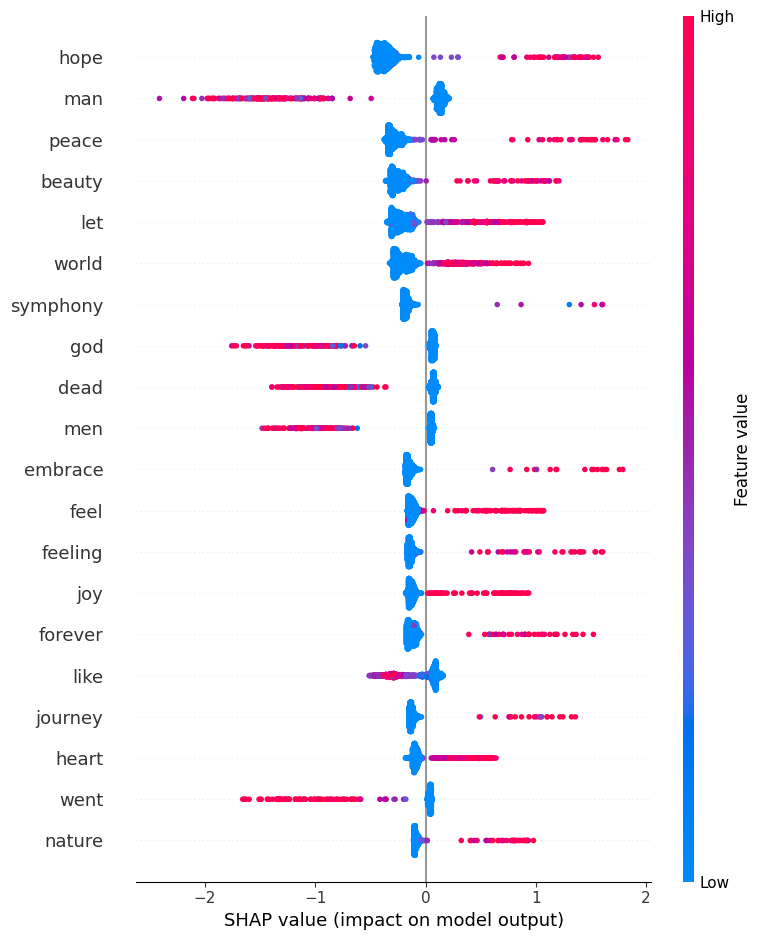

In [19]:
### INTERPRETABILITY - SHAP VALUES

explainer_111 = shap.Explainer(classifier_111.classifier)

if hasattr(X_test_poetry_111, "toarray"):
    X_test_poetry_111 = X_test_poetry_111.toarray()

# Calculate SHAP values
shap_values_111 = explainer_111(X_test_poetry_111)


# Visualize the SHAP values
shap.summary_plot(shap_values_111, X_test_poetry_111, feature_names=dim_names_111)

## **CLASSIFICATION USING TF-IDF & RANDOM FOREST**

In [20]:
ID_EXPERIMENT = 121

In [21]:
### EMBEDDING

embedding_121 = TfIdfEmbedding(ID_EXPERIMENT)

embedding_121.fit(X=X_train_poetry)

X_train_poetry_121 = embedding_121.transform(X=X_train_poetry)
X_test_poetry_121 = embedding_121.transform(X=X_test_poetry)
X_test_essay_121 = embedding_121.transform(X=X_test_essay)
X_test_story_121 = embedding_121.transform(X=X_test_story)

In [22]:
### CLASSIFIER

classifier_121 = RFClassifier(ID_EXPERIMENT)

classifier_121.train(X_train=X_train_poetry_121, y_train=y_train_poetry)

metrics_poetry_121 = classifier_121.evaluate(X_test_poetry_121, y_test_poetry)
metrics_essay_121 = classifier_121.evaluate(X_test_essay_121, y_test_essay)
metrics_story_121 = classifier_121.evaluate(X_test_story_121, y_test_story)

print(f"Metrics on poetry: {metrics_poetry_121}")
print(f"Metrics on essay: {metrics_essay_121}")
print(f"Metrics on story: {metrics_story_121}")

Metrics on poetry: {'accuracy': 0.3963068181818182, 'precision': 0.5170454545454546, 'recall': 0.6915820029027576, 'f1': 0.3099869700079564}
Metrics on essay: {'accuracy': 0.8007380073800738, 'precision': 0.6538461538461539, 'recall': 0.8906882591093117, 'f1': 0.6739304812834225}
Metrics on story: {'accuracy': 0.5454545454545454, 'precision': 0.53315649867374, 'recall': 0.5416666666666667, 'f1': 0.5139625309296572}


## **CLASSIFICATION USING TF-IDF & NAIVE BAYES**

In [23]:
ID_EXPERIMENT = 131

In [24]:
### EMBEDDING

embedding_131 = TfIdfEmbedding(ID_EXPERIMENT)

embedding_131.fit(X=X_train_poetry)

X_train_poetry_131 = embedding_131.transform(X=X_train_poetry)
X_test_poetry_131 = embedding_131.transform(X=X_test_poetry)
X_test_essay_131 = embedding_131.transform(X=X_test_essay)
X_test_story_131 = embedding_131.transform(X=X_test_story)

In [25]:
### CLASSIFIER

classifier_131 = NBClassifier(ID_EXPERIMENT)

classifier_131.train(X_train=X_train_poetry_131, y_train=y_train_poetry)

metrics_poetry_131 = classifier_131.evaluate(X_test_poetry_131, y_test_poetry)
metrics_essay_131 = classifier_131.evaluate(X_test_essay_131, y_test_essay)
metrics_story_131 = classifier_131.evaluate(X_test_story_131, y_test_story)

print(f"Metrics on poetry: {metrics_poetry_131}")
print(f"Metrics on essay: {metrics_essay_131}")
print(f"Metrics on story: {metrics_story_131}")

Metrics on poetry: {'accuracy': 0.3565340909090909, 'precision': 0.516025641025641, 'recall': 0.6712626995645864, 'f1': 0.28619103575625315}
Metrics on essay: {'accuracy': 0.9188191881918819, 'precision': 0.7608695652173914, 'recall': 0.9554655870445344, 'f1': 0.8195520581113802}
Metrics on story: {'accuracy': 0.7272727272727273, 'precision': 0.6689189189189189, 'recall': 0.6875, 'f1': 0.6753246753246753}
